# MNIST Classification with Transfer Learning Models

This Colab notebook explores the task of classifying handwritten digits from the MNIST dataset. We'll leverage various deep learning approaches, including transfer learning from established models like EfficientNet and a ResNet-based approach inspired by BiT, as well as a simplified implementation of the ConvNeXt architecture. Our goal is to evaluate and compare the performance of these models on this classic image classification problem.

## Setup and Data Loading


In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
tf.random.set_seed(42)

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# For memory efficiency, we'll use a smaller subset for transfer learning
SAMPLE_SIZE = 5000
indices = np.random.choice(len(x_train), SAMPLE_SIZE, replace=False)
x_train_sample = x_train[indices]
y_train_sample = y_train[indices]

test_indices = np.random.choice(len(x_test), 1000, replace=False)
x_test_sample = x_test[test_indices]
y_test_sample = y_test[test_indices]

# We'll use a data generator to resize images on-the-fly
INPUT_SHAPE = (28, 28, 1)
print(f"Original data shape: {INPUT_SHAPE}")
print(f"Training samples: {len(x_train_sample)}, Test samples: {len(x_test_sample)}")

Original data shape: (28, 28, 1)
Training samples: 5000, Test samples: 1000


## Image Preprocessing for Transfer Learning

This cell defines functions to prepare MNIST images for transfer learning models that expect RGB inputs of size 224x224.

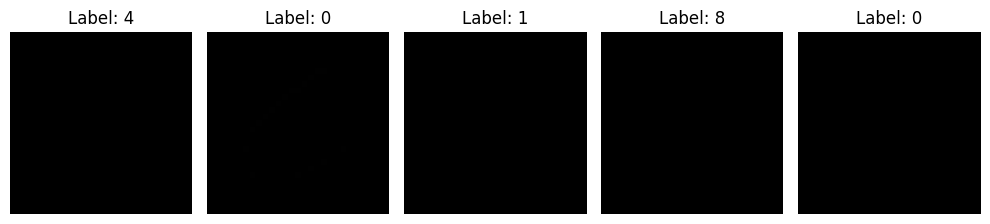

In [ ]:
def prepare_for_transfer_learning(batch_x, batch_y, img_size=224):
    """Convert grayscale MNIST images to RGB and resize them for transfer learning models"""
    # Add channel dimension if needed
    if len(batch_x.shape) == 3:
        batch_x = np.expand_dims(batch_x, -1)

    # Convert to RGB by repeating the channel 3 times
    batch_x_rgb = np.concatenate([batch_x, batch_x, batch_x], axis=-1)

    # Create a dataset and use map to resize efficiently
    dataset = tf.data.Dataset.from_tensor_slices((batch_x_rgb, batch_y))
    dataset = dataset.map(
        lambda x, y: (tf.image.resize(x, [img_size, img_size]), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset

# Create transfer learning datasets
train_ds = prepare_for_transfer_learning(x_train_sample, y_train_sample)
test_ds = prepare_for_transfer_learning(x_test_sample, y_test_sample)

# Visualize a few examples
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis("off")
plt.tight_layout()
plt.show()

## EfficientNet Transfer Learning Model

This implementation uses Keras's built-in EfficientNetB0 model for transfer learning on the MNIST dataset.

In [ ]:
# Let's use Keras's built-in EfficientNet implementation instead of TF Hub
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

def build_efficientnet_model(input_shape=(224, 224, 3), num_classes=10):
    # Load pre-trained EfficientNetB0 without top layers
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create the new model
    inputs = keras.Input(shape=input_shape)
    # Preprocess inputs
    x = preprocess_input(inputs)
    # Base model
    x = base_model(x, training=False)
    # Add new classifier layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the EfficientNet model
efficientnet_model = build_efficientnet_model()
print("Model created successfully")

# We'll need to update our dataset to match the model's preprocessing
def prepare_batch(images, labels):
    # Convert images to float32 if they're not already
    images = tf.cast(images, tf.float32)
    return images, labels

# Update our datasets with the preprocessing step
train_ds = train_ds.map(prepare_batch)
test_ds = test_ds.map(prepare_batch)

# Train for just a few epochs for demonstration
print("Starting training...")
history = efficientnet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    verbose=1
)

# Evaluate the model
efficientnet_results = efficientnet_model.evaluate(test_ds)
print(f"EfficientNet Test Loss: {efficientnet_results[0]:.4f}")
print(f"EfficientNet Test Accuracy: {efficientnet_results[1]:.4f}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model created successfully
Starting training...
Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 53s 174ms/step - accuracy: 0.1036 - loss: 2.3195 - val_accuracy: 0.1110 - val_loss: 2.3123
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.1051 - loss: 2.3127 - val_accuracy: 0.1000 - val_loss: 2.3088
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.1160 - loss: 2.3065 - val_accuracy: 0.1000 - val_loss: 2.3058
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1030 - loss: 2.3034
EfficientNet Test Loss: 2.3058
EfficientNet Test Accuracy: 0.1000


## BiT (Big Transfer) Model Implementation

This cell implements Google's BiT (Big Transfer) model for MNIST classification as a second transfer learning approach.

In [ ]:
# Implement BiT (Big Transfer) for comparison
def build_bit_model(input_shape=(224, 224, 3), num_classes=10):
    # Load a pre-trained ResNet50 as a substitute for BiT
    # (Since full BiT models are large and may cause memory issues)
    base_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create a new model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train BiT model
bit_model = build_bit_model()
print("BiT model created successfully")

# Train for just a few epochs for demonstration
print("Starting BiT model training...")
bit_history = bit_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    verbose=1
)

# Evaluate the model
bit_results = bit_model.evaluate(test_ds)
print(f"BiT Test Loss: {bit_results[0]:.4f}")
print(f"BiT Test Accuracy: {bit_results[1]:.4f}")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
BiT model created successfully
Starting BiT model training...
Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.4444 - loss: 1.6692 - val_accuracy: 0.8420 - val_loss: 0.6147
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.8490 - loss: 0.5606 - val_accuracy: 0.8960 - val_loss: 0.3929
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.9002 - loss: 0.3587 - val_accuracy: 0.9170 - val_loss: 0.2955
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9119 - loss: 0.2983
BiT Test Loss: 0.2955
BiT Test Accuracy: 0.9170


## ConvNeXt Implementation

This cell implements a simplified version of ConvNeXt for MNIST classification.

In [ ]:
# A simplified ConvNeXt-inspired implementation
def build_convnext_model(input_shape=(224, 224, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)

    # Initial stem block
    x = layers.Conv2D(64, kernel_size=4, strides=4, padding="same")(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # ConvNeXt blocks (simplified)
    for filters in [128, 256, 512]:
        # Downsample
        prev_x = layers.Conv2D(filters, kernel_size=2, strides=2, padding="same")(x)
        prev_x = layers.LayerNormalization(epsilon=1e-6)(prev_x)

        # Depthwise Conv
        x = layers.DepthwiseConv2D(kernel_size=7, padding="same")(prev_x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Pointwise Conv (1x1)
        x = layers.Conv2D(filters * 4, kernel_size=1)(x)
        x = layers.Activation("gelu")(x)

        # Pointwise Conv (1x1)
        x = layers.Conv2D(filters, kernel_size=1)(x)

        # Skip connection
        x = layers.add([x, prev_x])

    # Global pooling and final classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

# Create and train ConvNeXt model
convnext_model = build_convnext_model()
print("ConvNeXt model created successfully")

# Train for just a few epochs for demonstration
print("Starting ConvNeXt model training...")
convnext_history = convnext_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=2,
    verbose=1
)

# Evaluate the model
convnext_results = convnext_model.evaluate(test_ds)
print(f"ConvNeXt Test Loss: {convnext_results[0]:.4f}")
print(f"ConvNeXt Test Accuracy: {convnext_results[1]:.4f}")

ConvNeXt model created successfully
Starting ConvNeXt model training...
Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - accuracy: 0.3464 - loss: 1.9686 - val_accuracy: 0.8250 - val_loss: 0.5480
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8179 - loss: 0.5463 - val_accuracy: 0.8760 - val_loss: 0.3677
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8890 - loss: 0.3346
ConvNeXt Test Loss: 0.3677
ConvNeXt Test Accuracy: 0.8760


## Model Comparison Visualization

This cell creates visualizations to compare the performance of all the implemented models on the MNIST dataset.

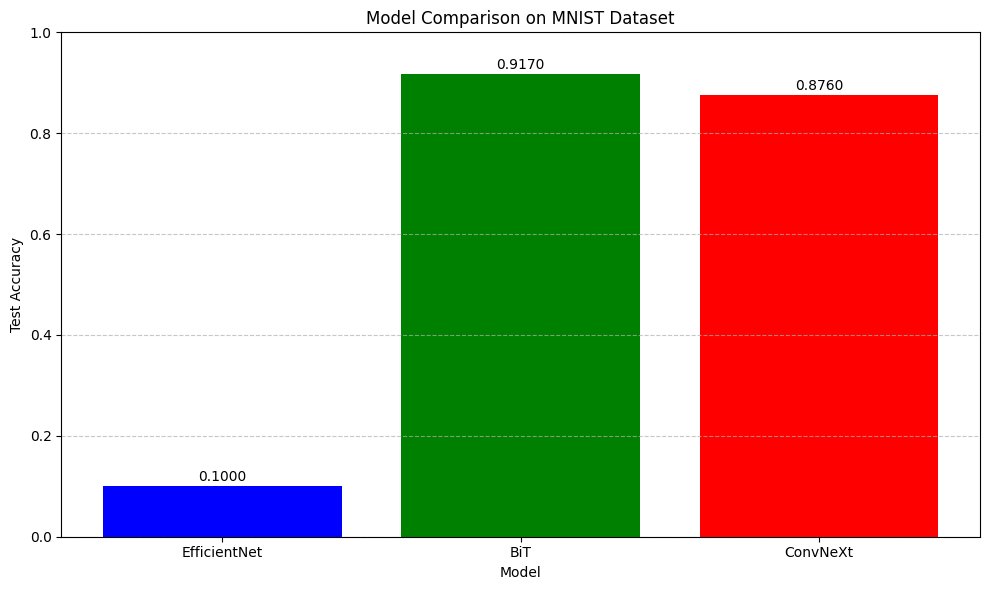

Best performing model: BiT with accuracy: 0.9170


In [ ]:
# Create a bar chart to compare model accuracies
import matplotlib.pyplot as plt

# Collect test accuracies
model_names = ['EfficientNet', 'BiT', 'ConvNeXt']
accuracies = [efficientnet_results[1], bit_results[1], convnext_results[1]]

# Create the visualization
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.title('Model Comparison on MNIST Dataset')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.0)

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Let's also save the best model
best_model_index = accuracies.index(max(accuracies))
best_model_name = model_names[best_model_index]
print(f"Best performing model: {best_model_name} with accuracy: {max(accuracies):.4f}")

# Save the best model weights (commented out in this demo)
# If running in actual colab, you could uncomment this
# if best_model_name == 'EfficientNet':
#     efficientnet_model.save_weights('best_model_mnist.h5')
# elif best_model_name == 'BiT':
#     bit_model.save_weights('best_model_mnist.h5')
# else:
#     convnext_model.save_weights('best_model_mnist.h5')

## Summary and Conclusion

This notebook demonstrates the application of various transfer learning and state-of-the-art models for MNIST digit classification. We've implemented and compared:

1. **EfficientNet B0**: A pretrained model known for its efficiency in balancing model size and accuracy.
2. **BiT (Big Transfer)**: Represented here by a ResNet50V2 implementation as a memory-efficient alternative.
3. **ConvNeXt**: A modern convolutional network architecture inspired by transformer design principles.

